In [1]:
# import required libraries

# kagglehub helps us download the dataset
import kagglehub

# torch and torchvision by PyTorch are popular Python libraries for
# Neural Network (NN) and Machine Learning (ML) applications
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, utils as vutils
from torchvision.datasets import ImageFolder

# numpy is a numerical processing library for python that contains a 
# very useful n-dimensional array structure called the ndarray (among
# other things). It's also closely integrated with many other python
# libraries.
import numpy as np

# matplotlib is a tool for creating and displaying graphs and plots
# in python - it will come in handy for data visualisation. It's also
# closely integrated with numpy.
import matplotlib.pyplot as plt

# pillow is a Python library for handling images. We use it to save the 
# images generated by our model. It's also closely integrated with numpy.
from PIL import Image

# os is part of Python's standard library and allows us to interact with
# files and folders on the system among other things 
import os

c:\Users\finle\.conda\envs\torch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define training device

# train on cuda-compatible gpu if available, else cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# print the device being used
if device == 'cuda':
    print("GPU found.")
else:
    print("No GPT found. Training on CPU.")

GPU found.


In [3]:
# define constants

# size of images model handles
imsize = 64

# training batch size
batch_size = 256 if device == "cuda" else 128

# number of channels in the images the model handles
nchannel = 3

# dimension of z, the latent vector/input to the generator
latent_vec_size = 100

# number of features in the generator
generator_features = 64

# number of features in the discriminator
discriminator_features = 64

# learning rate for optimizers
learn_rate = 0.0002

# beta parameters for optimizers
betas = (0.5, 0.99)

# number of iterations the training loop repeats for
epochs = 30

In [4]:
# prepare data

# download CelebFaces Attributes (CelebA) dataset
dataset_path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print("Path to dataset files:", dataset_path)

# define a transform to apply to inputs
load_transform = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# create an ImageFolder dataset and a DataLoader
dataset = ImageFolder(dataset_path, transform=load_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Path to dataset files: C:\Users\finle\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2


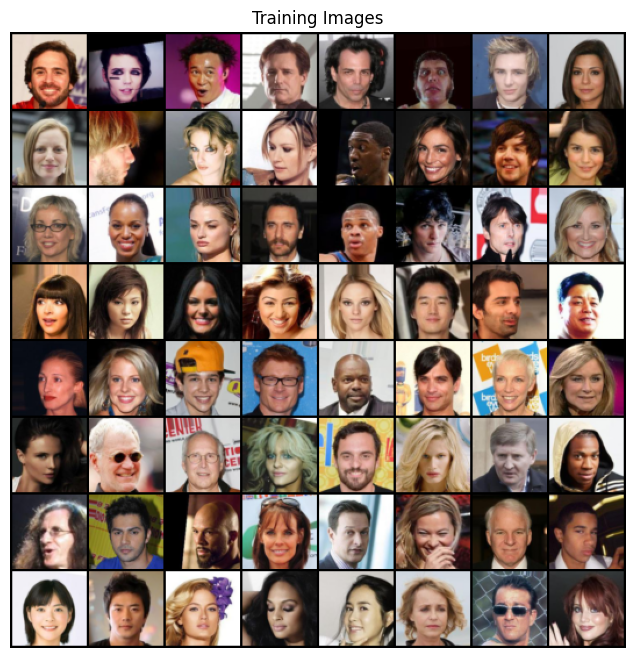

In [5]:
# display some sample data

# this section is copied directly from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html?highlight=dcgan.
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [6]:
# define the Generator model
class Generator(nn.Module):
    def __init__(self, 
                 input_dim=latent_vec_size,
                 hidden_dim=generator_features,
                 output_dim=nchannel) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(input_dim, hidden_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim * 8, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim, output_dim, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor):
        return self.main(x)

In [7]:
# define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self,
                 input_dim=nchannel,
                 hidden_dim=discriminator_features) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor):
        return self.main(x)

In [8]:
# function to initialise the model weights

# this section is copied directly from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html?highlight=dcgan.

# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# create the generator
G = Generator().to(device)

# apply the weights_init function to the generator
G.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [10]:
# create the discriminator
D = Discriminator().to(device)

# apply the weights_init function to the discriminator
D.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(

In [11]:
# define loss function and optimizers
criterion = nn.BCELoss()
D_optim = optim.Adam(D.parameters(), lr=learn_rate, betas=betas)
G_optim = optim.Adam(G.parameters(), lr=learn_rate, betas=betas)

In [12]:
# train the models for an epoch
def train(print_every=50):

    for i, (real_inputs, _) in enumerate(dataloader):
        
        # NOTE: bsz stores the size of the current batch, while batch_size
        # stores the preferred size for batches
        bsz = real_inputs.size(0)
        
        # prepare train the discriminator
        D.zero_grad()
        real_inputs = real_inputs.to(device)
        real_targets = torch.ones((bsz,), dtype=torch.float, device=device)
        
        # train the discriminator on real images
        real_output = D(real_inputs).view(-1)
        D_real_loss = criterion(real_output, real_targets)

        # generate random latent vectors
        latent_vectors = torch.randn(bsz, latent_vec_size, 1, 1, device=device)

        # generate fake images
        fake_inputs = G(latent_vectors)
        fake_targets = torch.zeros((bsz,), dtype=torch.float, device=device)

        # train the discriminator on fake images
        fake_outputs = D(fake_inputs.detach()).view(-1)
        D_fake_loss = criterion(fake_outputs, fake_targets)

        # perform back-propogation on the discriminator
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optim.step()

        # prepare to train the discriminator
        G.zero_grad()

        # perform another pass through D with its updated parameters
        fake_outputs = D(fake_inputs).view(-1)

        # perform back-propogation on the generator
        G_loss = criterion(fake_outputs, real_targets)
        G_loss.backward()
        G_optim.step()

        if i % print_every == 0:
            print(f'batch {i}, discriminator loss {D_loss.item():.4f}, generator loss: {G_loss.item():.4f}')

In [ ]:
# put the models in training mode
D.train()
G.train()

# train the models for the desired number of epochs
for i in range(1, 1 + epochs):
    # print the epoch number
    print(f'epoch {i}')

    # train for an epoach
    train()

epoch 1
batch 0, discriminator loss 1.5142, generator loss: 4.8356
batch 50, discriminator loss 0.2151, generator loss: 5.8952
batch 100, discriminator loss 0.3697, generator loss: 7.9719
batch 150, discriminator loss 5.1066, generator loss: 4.1543
batch 200, discriminator loss 0.7006, generator loss: 6.2327
batch 250, discriminator loss 0.6938, generator loss: 5.0933
batch 300, discriminator loss 1.7675, generator loss: 3.6118
batch 350, discriminator loss 0.6458, generator loss: 4.2365
batch 400, discriminator loss 0.4624, generator loss: 3.7887
batch 450, discriminator loss 0.6035, generator loss: 4.9291
batch 500, discriminator loss 1.3893, generator loss: 3.1391
batch 550, discriminator loss 0.8543, generator loss: 3.5290
batch 600, discriminator loss 0.5131, generator loss: 4.4194
batch 650, discriminator loss 0.6358, generator loss: 6.3758
batch 700, discriminator loss 0.6016, generator loss: 5.2473
batch 750, discriminator loss 0.4138, generator loss: 5.3035
epoch 2
batch 0, di

In [33]:
def toim(tens: torch.Tensor, batch_first=False) -> Image:
    """
    Function to convert a PyTorch tensor to a PIL Image
    """

    # detach from gradient and move off gpu if available
    tens = tens.detach().cpu()

    # scale output images
    tens = (tens + 1) / 2
    tens = (tens * 255).clamp(0, 255)

    # convert to integers
    tens = tens.to(torch.uint8)

    if batch_first:
        # permute and convert to numpy
        arr = tens.permute(0, 2, 3, 1).numpy()

        # return images
        return [Image.fromarray(i) for i in arr]
    else:
        # permute and convert to numpy
        arr = tens.permute(1, 2, 0).numpy()

        # return the image
        return Image.fromarray(arr)

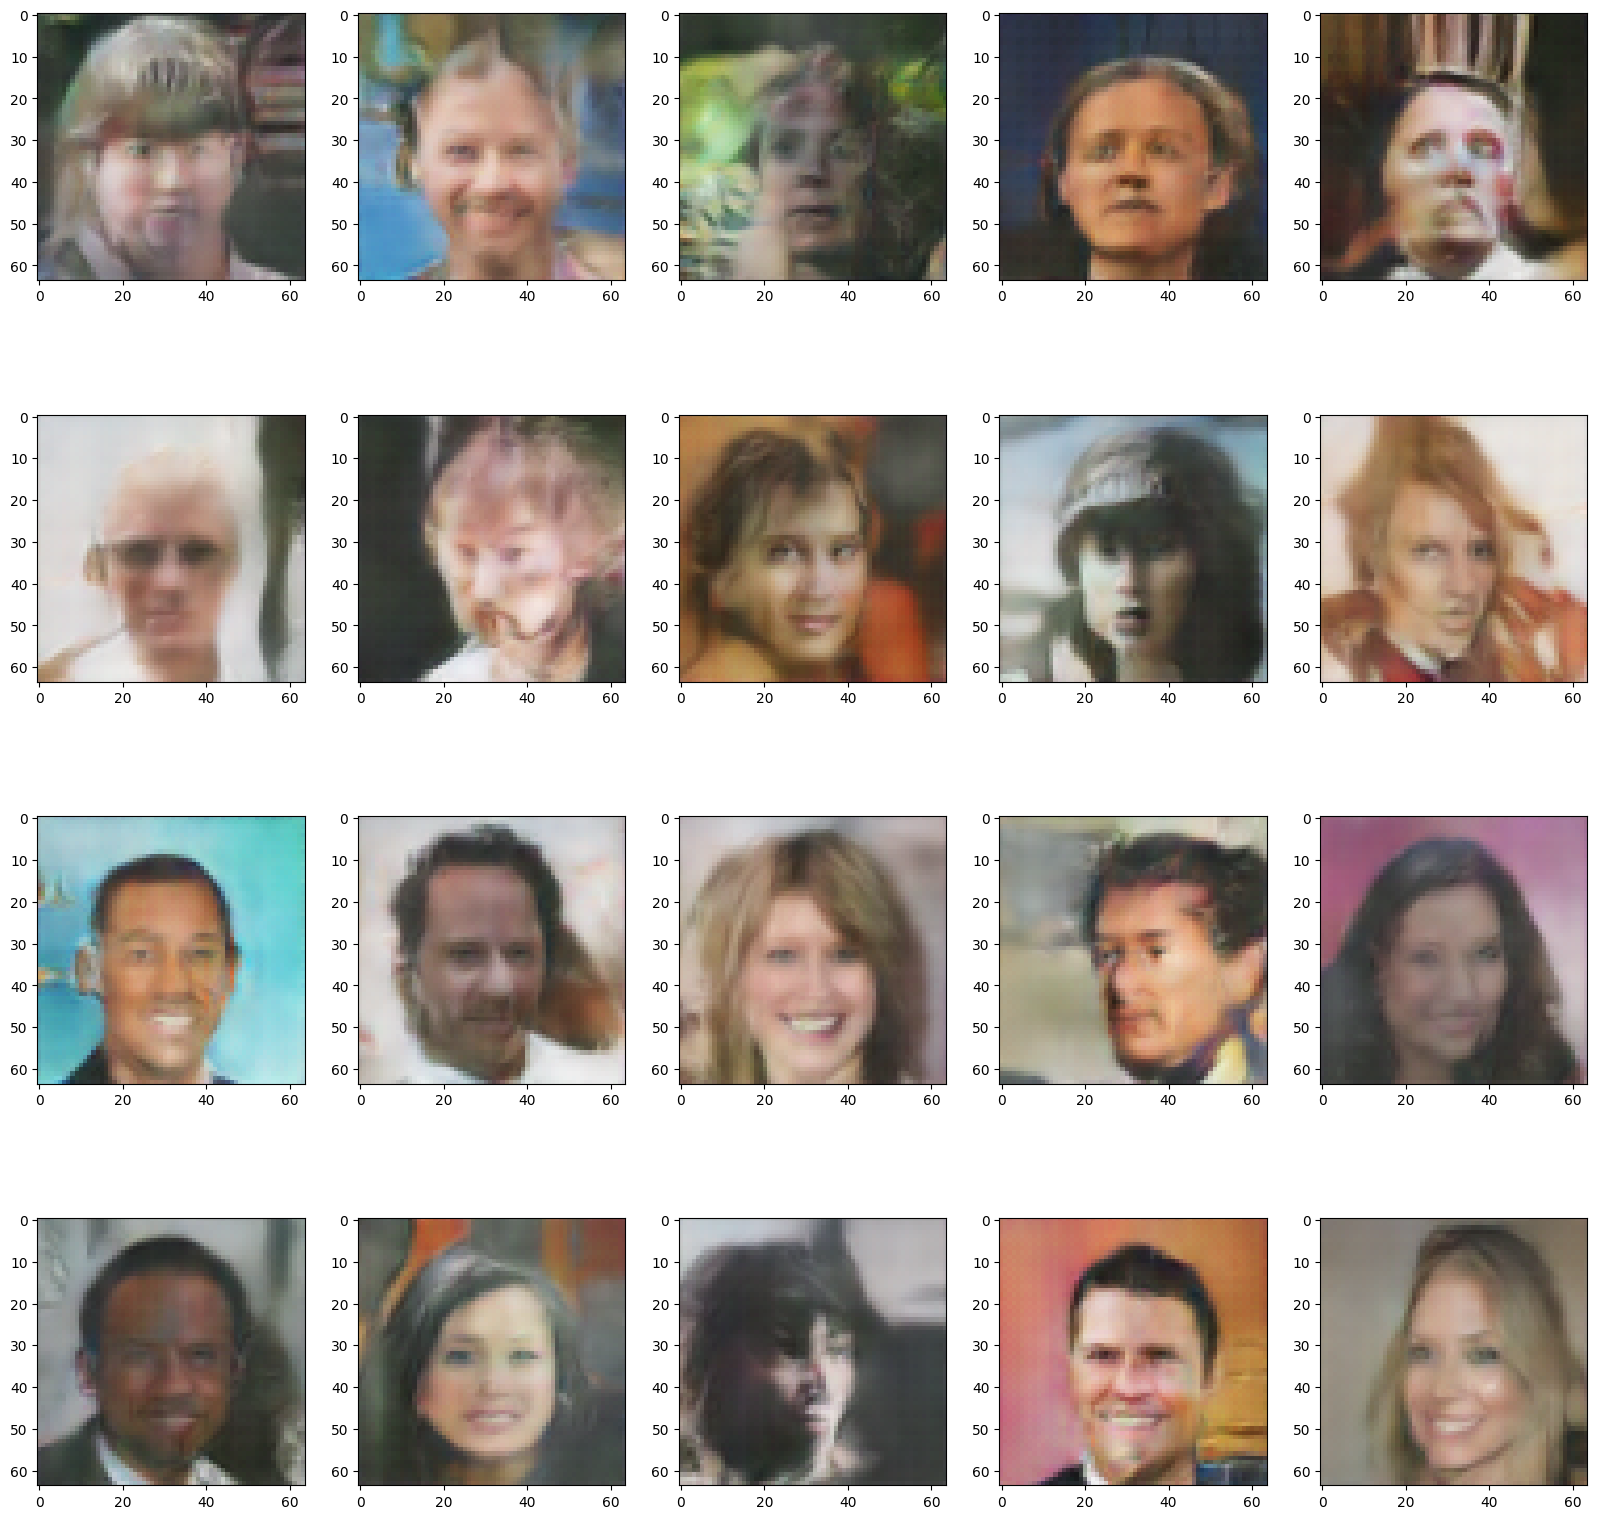

In [ ]:
# generate, plot, and save images

# name of the directory to place generated images
outdir = "generated_ims"

# create the diretory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

# define the grid size
nrows, ncols = 4, 5

# define the figure and axes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=[20, 20])

# generate some images
latent_vector = torch.randn(nrows * ncols, latent_vec_size, 1, 1, dtype=torch.float, device=device)
images: torch.Tensor = G(latent_vector)
images = toim(images, batch_first=True)

# plot generated images
for row_id, row in enumerate(axes):
    for col_id, axis in enumerate(row):
        i = row_id * ncols + col_id
        axis.imshow(images[i])
        images[i].save(f"{outdir}/im-{i + 1}.jpg")

In [ ]:
# save the generator model
torch.save(G, f'generator-{epochs}-epoch.pth')